# Fitting a self organizing map to in-game data 

The file `q3dm1-path1.csv` contains a sequence


$$x[1] : x[2] : x[3] : x[4] : · · · : x[n]$$


of $n = 1327$ 3D locations the avatar of a human player was seen at while moving around the Quake III map q3dm1.

- Note: if your fitted SOM looks “twisted”, then run the training algo- rithm again, until you obtain a better fit.
- Determine how well its weights $w_1, . . . , w_k$ represent the data with computing the mean squared error

In [1]:
import numpy.random as rnd 
import networkx as nx

def trainSOM(matX, G, tmax=1000, sigma0=1., eta0=1., k=20):
    m, n = matX.shape
    Giterx, Gitery, Giterz = [], [], []
    # compute matrix of squared path length distances between neurons
    # NOTE: networkx returns a numpy matrix, but we want a numpy array
    # because this allows for easy squaring of its entries
    matD = np.asarray(nx.floyd_warshall_numpy(G))**2
    # a list of tmax random indices into the columns of matrix X
    smpl = rnd.randint(0, n, size=tmax)
    for t in range(tmax):
        # sample a point x, i.e. a column of matrix X
        vecX = matX[:,smpl[t]]
        # determine the best matching unit
        b = np.argmin([np.sum((G.nodes[v]['w'] - vecX)**2) for v in G])
        # update the learning rate
        eta = eta0 * (1. - t/tmax)
        # update the topological adaption rate
        sigma = sigma0 * np.exp(-t/tmax)
        # update all weights
        for i, v in enumerate(G):
            # evaluate neighborhood function
            h = np.exp(-0.5 * matD[b,i] / sigma**2)
            G.nodes[v]['w'] += eta * h * (vecX - G.nodes[v]['w'])
        xi, yi, zi = xyztemp(G, k)
        #print(xi)
        Giterx.append(xi), Gitery.append(yi), Giterz. append(zi)
        
    return G, Giterx, Gitery, Giterz

In [2]:
def xyztemp(SOM1, k):
    x1, y1, z1 = [], [], []
    for i in range(k-1):
        tempx,tempy,tempz = SOM1.nodes[i]['w']
        x1.append(tempx), y1.append(tempy), z1.append(tempz)
    
    tempx,tempy,tempz = SOM1.nodes[0]['w']
    x1.append(tempx), y1.append(tempy), z1.append(tempz)
        
    return x1,y1,z1
    


In [3]:
import networkx as nx

def initRingSOM(matX, k):
    G = nx.generators.lattice.grid_2d_graph(k, 1, periodic=True)
    G = nx.convert_node_labels_to_integers(G)
    m, n = matX.shape
    smpl = rnd.choice(n, k, replace=False)
    for i, v in enumerate(G):
        G.nodes[v]['w'] = matX[:,smpl[i]]
    return G

In [4]:
from numpy import linalg as LA
from scipy.spatial import distance

def compute_MSE(matX, weights):
    m, n = matX.shape
    
    print(n)
    E=np.zeros(n)
    #for w in weights.T:
    #    print('w', w)
    for t in range(n):
        E[t] = 1/n * np.min([distance.euclidean(matX[:, t], w)**2 for w in weights.T])
    print("E for task 5(b): ", np.around(np.sum(E), decimals=2))
    return E

In [8]:
%matplotlib notebook
import matplotlib.pyplot as plt
import csv
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import time
import numpy.random as rnd 


def plot_SOM(data_path, k = 24, max_iter = 10000):
    x = []
    y = []
    z = []

    with open(data_path,'r') as csvfile:
        plots = csv.reader(csvfile, delimiter=',')
        for row in plots:
            x.append(float(row[0]))
            y.append(float(row[1]))
            z.append(float(row[2]))

    data = np.vstack((x,y,z))
    print(data.shape)

    matX = data

    SOM1 = initRingSOM(matX, k)
    print(SOM1.nodes)

    fig = plt.figure()
    #fig.set_figheight(15)
    #fig.set_figwidth(15)
    ax = fig.add_subplot(111, projection='3d')
    plt.ion()

    fig.show()
    fig.canvas.draw()

    ax.clear()

    SOM1, Gx, Gy, Gz = trainSOM(matX, SOM1, tmax = max_iter, k = k)
    
    computed_weights = np.asarray([Gx[max_iter-1], Gy[max_iter-1], Gz[max_iter-1]])
    #print('comp', computed_weights)
    
    compute_MSE(matX, computed_weights)
    nx.write_gpickle(SOM1, 'som.gpickle')
    
    for iter in (10, max_iter-1):
        ax.clear()
        ax.scatter(x , y, z, color = "black", alpha=0.3, s = 1, label='The data first csv')
        ax.plot(Gx[int(iter)], Gy[int(iter)], Gz[int(iter)], 'o-', color = "blue", alpha=0.3, label='Circle topology SOM')
        #ax.scatter(Gx[int(iter)], Gy[int(iter)], Gz[int(iter)], color = "red", s = 100, alpha=0.3, label='The data first csv')
        plt.xlabel('x')
        plt.ylabel('y')
        plt.title('Circle topology: iteration = '+str(iter))
        plt.legend()
        #plt.show()
        fig.canvas.draw()
        time.sleep(0.001)

(3, 1327)
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]


<IPython.core.display.Javascript object>


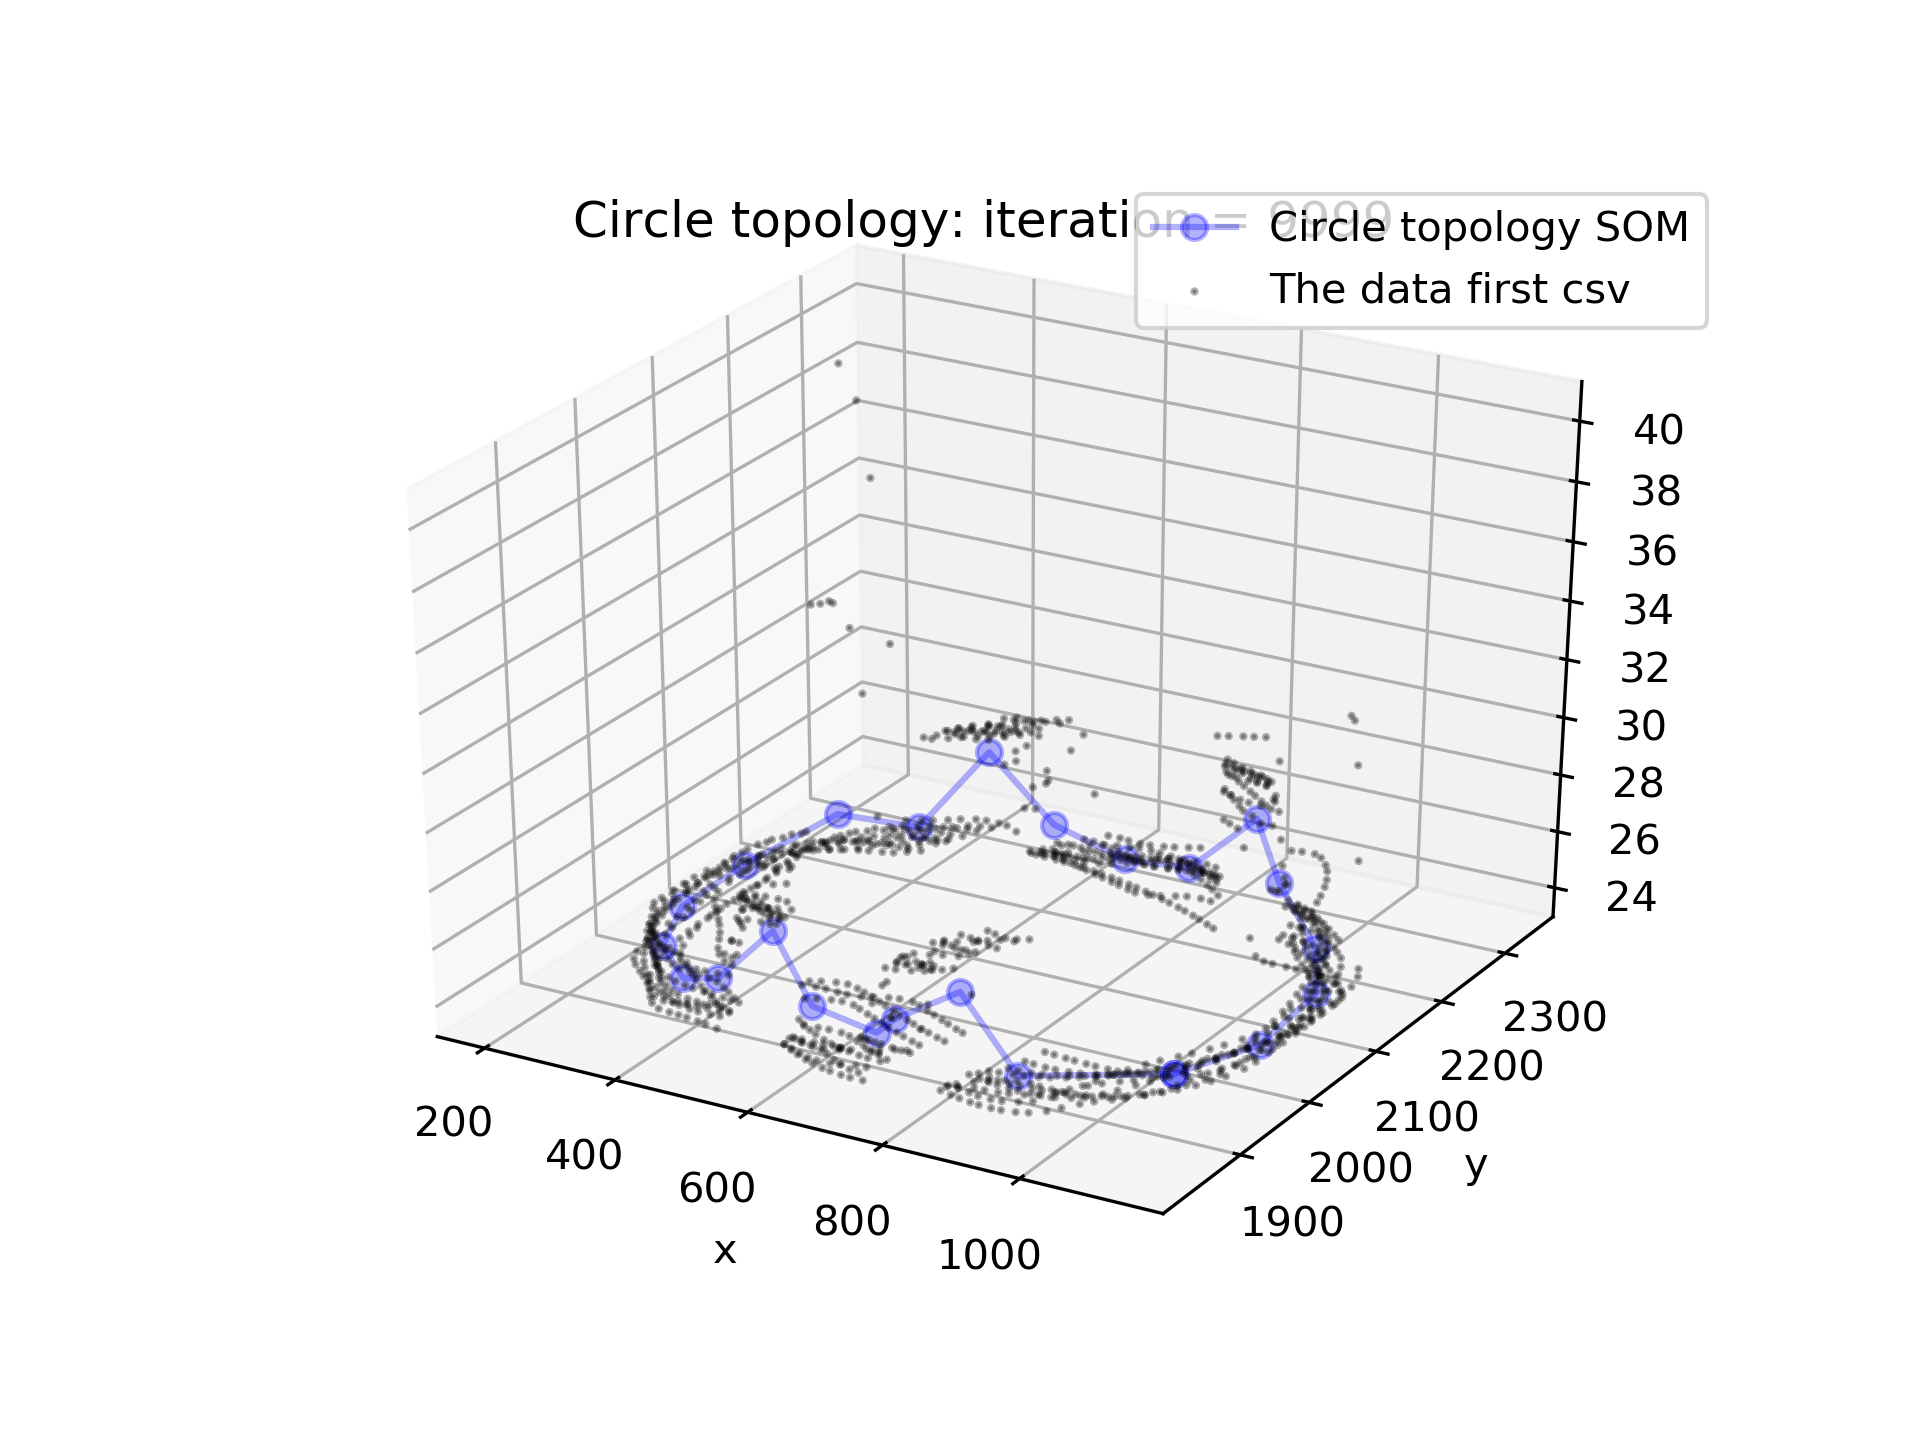

1327
E for task 5(b):  1506.12


In [9]:
plot_SOM("q3dm1-path1.csv", max_iter = 10000)

(3, 1288)
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]


<IPython.core.display.Javascript object>


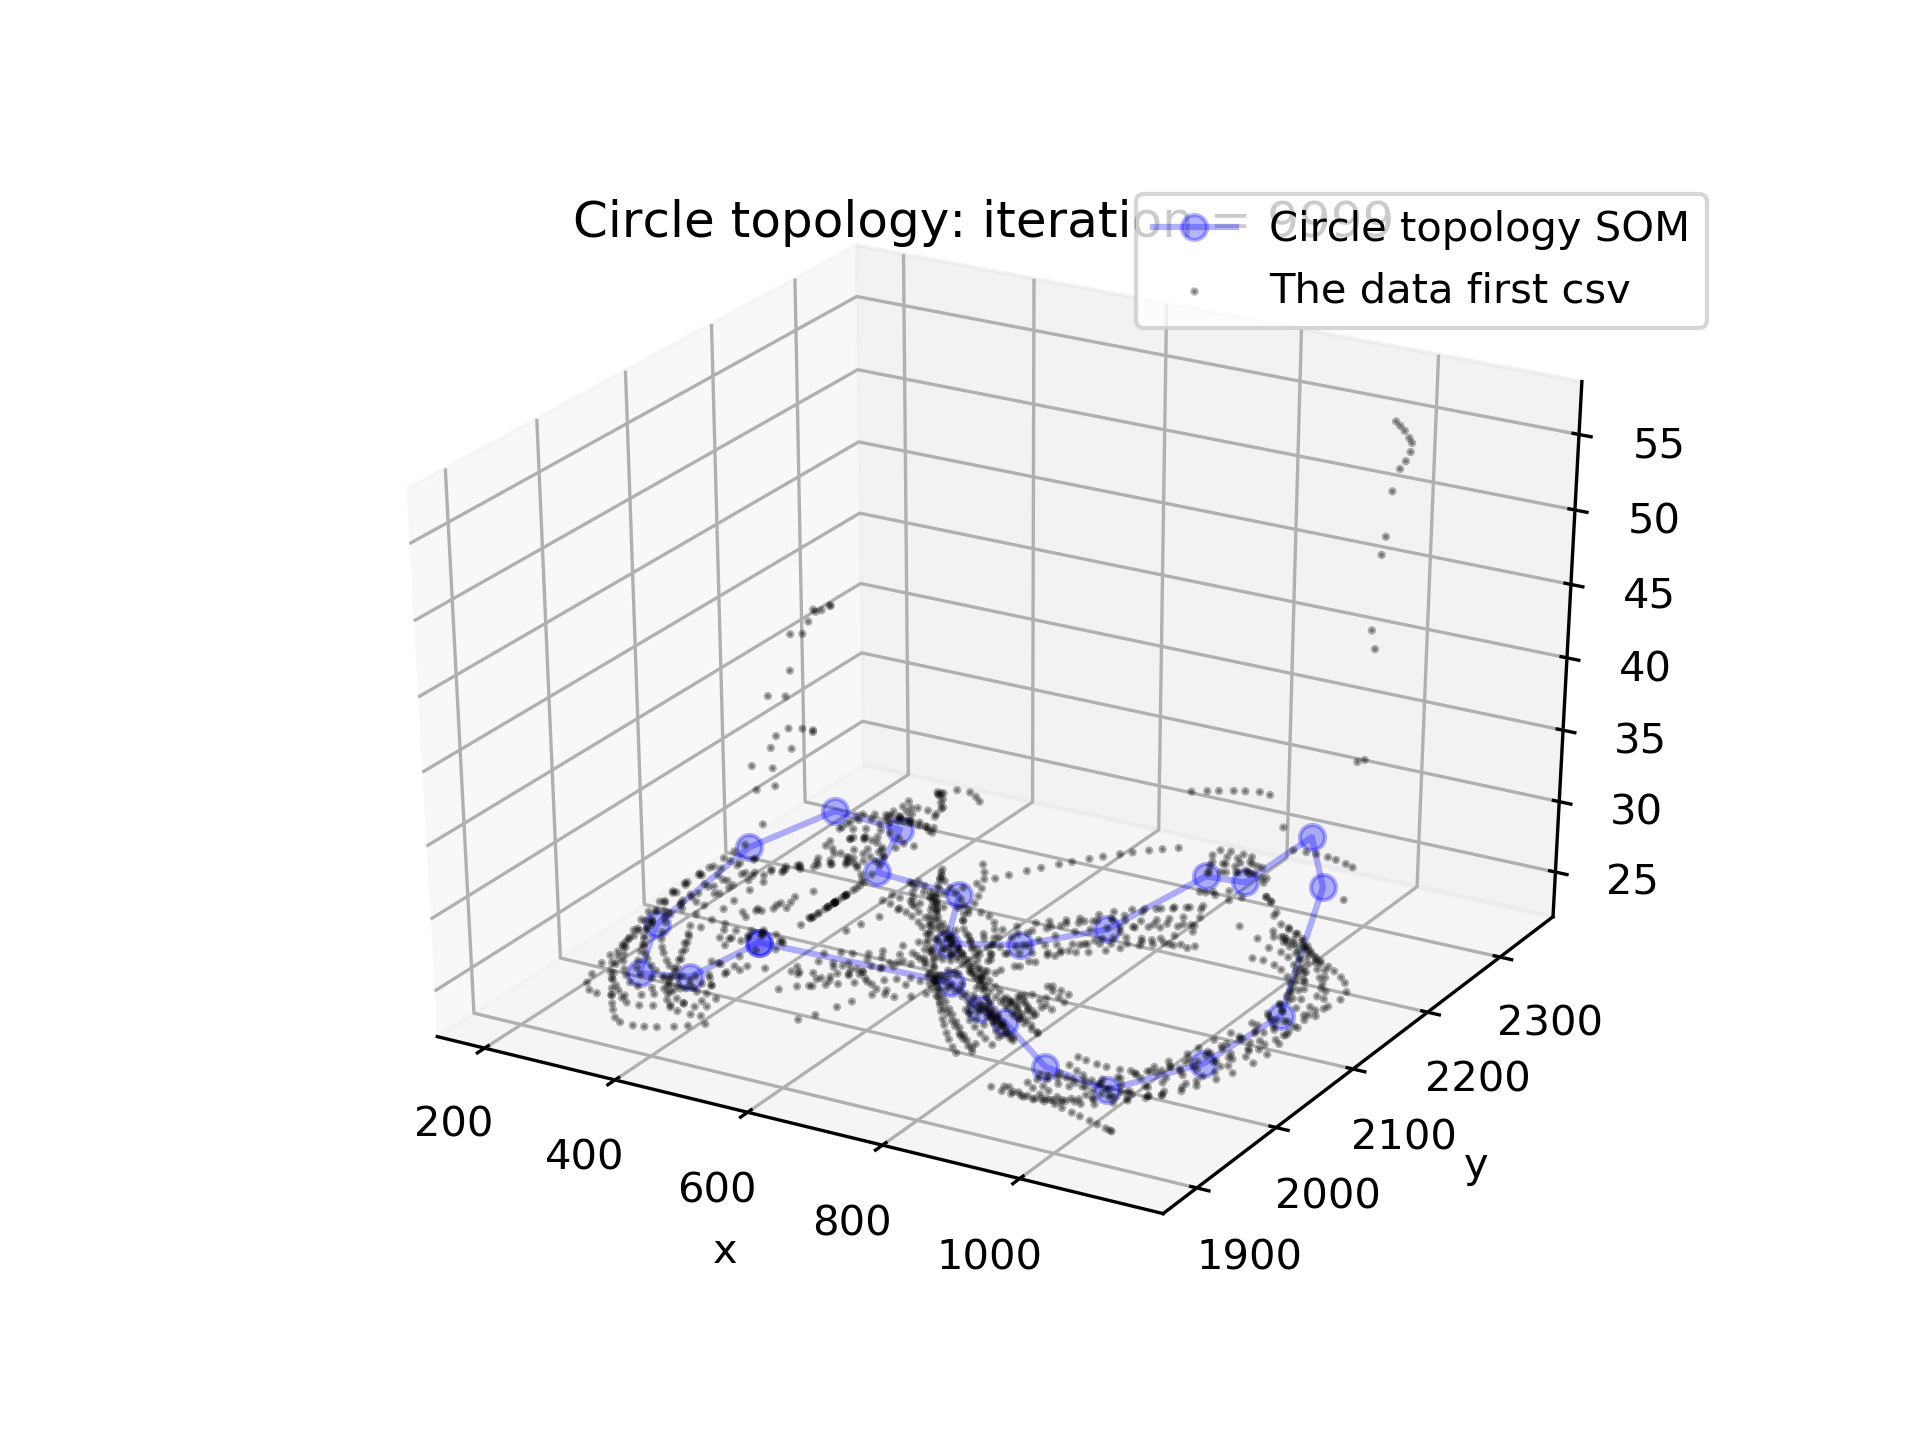

1288
E for task 5(b):  1874.22


In [10]:
# with other data
plot_SOM("q3dm1-path2.csv", max_iter = 10000)